## Skin Cancer Detection using the FastAI library

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
bs = 64 # dependent on GPU in use

### Obtaining the Dataset
Uncomment and run this section after first downloading the repo to get the data.

In [5]:
from pathlib import Path

In [6]:
path = Path('./data')
path

PosixPath('data')

In [7]:
! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign -p "{path}"
! unzip "{path}/skin-cancer-malignant-vs-benign.zip" -d "{path}"

skin-cancer-malignant-vs-benign.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  data/skin-cancer-malignant-vs-benign.zip
replace data/test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Now have the data...

## Data Visualization

In [8]:
path_train = path/'train'
path_test = path/'test'
path_train

PosixPath('data/train')

The data is labeled by folder. That sounds like a standard case for Image Data bunch

In [ ]:
(path/'train').ls()

Need to change transforms for both data blocks:

In [34]:
tfms = get_transforms(flip_vert=True, max_warp=0.1)

Should we use the test set for validation?

In [39]:
data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs).normalize(imagenet_stats)

Need to set up a validation set using the Datablock api

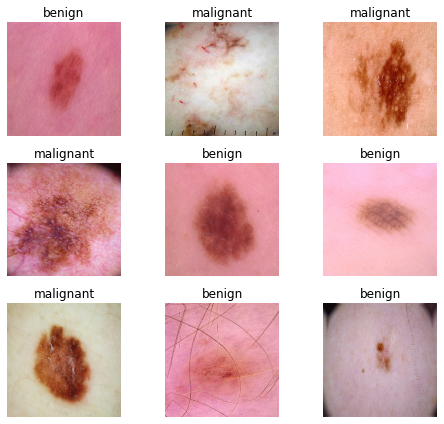

In [41]:
data.show_batch(rows=3,figsize=(7,6))

The images seems to be showing up pretty well. Size is already 224 by 224. All transforms seem to be valid, even lighting changes.

### Attempt using Resnet 34

In [51]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


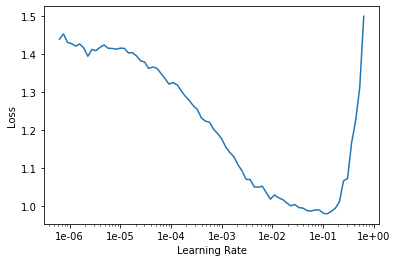

In [53]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.779968,0.554545,0.180577,00:10
1,0.547313,0.410913,0.163885,00:10
2,0.430748,0.384193,0.154780,00:10
3,0.353838,0.256675,0.109256,00:09
4,0.303794,0.255327,0.107739,00:09
5,0.259306,0.248601,0.107739,00:10


got to like .13 with 1-e3, .10 with 1e-2

In [55]:
learn.save('stage-1-rn34')

### Model Fine-tuning

In [56]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


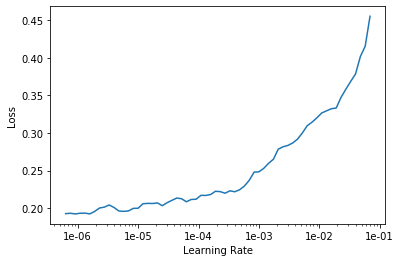

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(5, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.248311,0.328562,0.130501,00:13
1,0.266714,0.243537,0.118361,00:13
2,0.247116,0.270196,0.107739,00:13
3,0.223583,0.220320,0.103187,00:13
4,0.181274,0.229840,0.103187,00:13


In [59]:
learn.save('stage-2-rn34')

Should I add iterative resizing? Hard to tell if this can get under .103

## Resnet-50 Attempt
Just repeating the process using the resnet 50 model. 

In [67]:
torch.cuda.empty_cache()

In [66]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [62]:
data50 = data = ImageDataBunch.from_folder(path, train="/train", valid_pct=0.2,
                                  ds_tfms=tfms, size=224, bs=bs//2).normalize(imagenet_stats)

In [78]:
learn50 = cnn_learner(data50, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


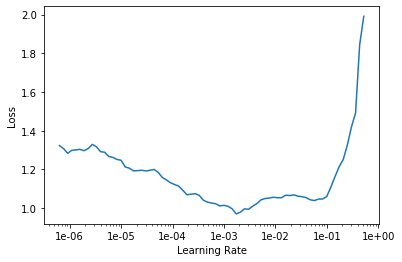

In [79]:
learn50.lr_find()
learn50.recorder.plot()

In [80]:
learn50.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.648869,0.512137,0.145675,00:20
1,0.498704,0.327320,0.144158,00:20
2,0.428151,0.332705,0.147193,00:20
3,0.351159,0.261671,0.119879,00:20
4,0.293867,0.209470,0.091047,00:21
5,0.224411,0.208506,0.095599,00:21


In [81]:
#learn50.save('stage-1-50')

In [82]:
#learn50.load('stage-1-50')

In [83]:
learn50.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


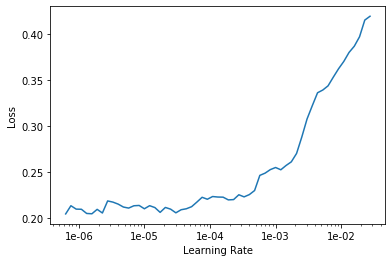

In [84]:
learn50.lr_find()
learn50.recorder.plot()

In [85]:
learn50.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.202793,0.210229,0.089530,00:28
1,0.234567,0.207922,0.089530,00:27
2,0.201701,0.195009,0.089530,00:27
3,0.178196,0.193943,0.080425,00:27
4,0.168079,0.189392,0.086495,00:27


In [3]:
learn50.save('stage-2-50')

NameError: name 'learn50' is not defined

### First results interpretation:
Turns out I can't actually read Cancer screening images, so I'm just going to go for the full training routine, and maybe we'll get someone to look at this later.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
#interp.plot_top_losses(9, figsize=(15,11))